# Subtask 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.utils import shuffle
import datetime
import pickle

In [2]:
## Read training data, labels, test data
train_data = pd.read_csv('dataset/train_features.csv', delimiter=',')
train_labels = pd.read_csv('dataset/train_labels.csv', delimiter=',')
test_data = pd.read_csv('dataset/test_features.csv', delimiter=',')

In [3]:
# sort train data and labels values by pid, so they are the same (because after with the manipulation of data things get nasty)
train_data =train_data.sort_values(['pid','Time'])
train_labels = train_labels.sort_values(['pid'])
test_data =test_data.sort_values(['pid','Time'])

In [4]:
train_labels

,pid,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2,LABEL_Sepsis,LABEL_RRate,LABEL_ABPm,LABEL_SpO2,LABEL_Heartrate
0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,12.1,85.4,100.0,59.9
6622,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,20.4,99.1,95.4,65.8
15008,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,17.8,78.8,97.4,71.8
16335,6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,17.9,75.1,97.3,80.7
17676,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.7,112.8,97.0,92.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14402,31653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.5,97.0,95.3,101.4
14403,31654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.2,119.2,97.6,91.8
14404,31656,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,21.0,93.8,99.2,92.2
14405,31657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.8,72.5,98.7,64.0


In [5]:
# set pid as index for labels (after it will be also for training data because we use the pivot function)
train_labels_1=train_labels.set_index('pid')
# labels needed for this subtask only up to LABEL_EtCO2
train_labels_1 = train_labels_1.iloc[:,10:11]

In [6]:
train_labels_1

,LABEL_Sepsis
pid,
1,0.0
2,0.0
4,0.0
6,0.0
8,0.0
...,...
31653,0.0
31654,0.0
31656,0.0


## Data imputation

In [7]:
# First part -> replace nan with the mean of the column
train_data_2_tmp1 = train_data.copy()
test_data_2_tmp1 = test_data.copy()

for col in train_data_2_tmp1.columns:
    #print(col)
    mean = train_data_2_tmp1[col].mean()
    train_data_2_tmp1[col] = train_data_2_tmp1[col].replace(np.nan,train_data_2_tmp1[col].mean())
#train_data_2_tmp1

for col in test_data_2_tmp1.columns:
    #print(col)
    mean = test_data_2_tmp1[col].mean()
    test_data_2_tmp1[col] = test_data_2_tmp1[col].replace(np.nan,test_data_2_tmp1[col].mean())

In [8]:
# normalise the values for each column
for col in train_data_2_tmp1.columns[2:]:
    #print(col)
    train_data_2_tmp1[col] = (train_data_2_tmp1[col] - train_data_2_tmp1[col].min()) / (train_data_2_tmp1[col].max() - train_data_2_tmp1[col].min())
    
for col in test_data_2_tmp1.columns[2:]:
    #print(col)
    test_data_2_tmp1[col] = (test_data_2_tmp1[col] - test_data_2_tmp1[col].min()) / (test_data_2_tmp1[col].max() - test_data_2_tmp1[col].min())

In [9]:
# Second part -> add columns with 0 and 1s to indicate if the measurement was taken or not

# change the name of the columns to be able to use the pivot function later
train_data_2_tmp2 = pd.DataFrame()
test_data_2_tmp2 = pd.DataFrame()
for col in train_data.columns[2:]:
    train_data_2_tmp2[col+'_2'] = train_data[col].copy() 
    
for col in test_data.columns[2:]:
    test_data_2_tmp2[col+'_2'] = test_data[col].copy() 

# substitute integers with 1
train_data_2_tmp2=train_data_2_tmp2.mask(train_data_2_tmp2>-9999,1)
test_data_2_tmp2=test_data_2_tmp2.mask(test_data_2_tmp2>-9999,1)
# substitute nan with 0
train_data_2_tmp2=train_data_2_tmp2.replace(np.nan,0)
test_data_2_tmp2=test_data_2_tmp2.replace(np.nan,0)

In [10]:
# concatenate part 1 and part2 for the complete set of training data
train_data_2 = pd.concat([train_data_2_tmp1, train_data_2_tmp2], axis=1)
test_data_2 = pd.concat([test_data_2_tmp1, test_data_2_tmp2], axis=1)

In [11]:
# Time Stamp between 1 and 12 (I simply replace it with numbers from 1 to 12) because we need it to use the pivot function after
    
train_data_2['Time']= np.array([[1,2,3,4,5,6,7,8,9,10,11,12] for i in range(int(len(train_data_2['Time'])/12))]).flatten()
test_data_2['Time']= np.array([[1,2,3,4,5,6,7,8,9,10,11,12] for i in range(int(len(test_data_2['Time'])/12))]).flatten()


In [12]:
# now we flatten the dataframe for each patient using the pivot function on the column Time
columns = train_data_2.columns
print(columns[2:])

train_data_2 = train_data_2.pivot(index='pid', columns='Time', values=columns[2:])
test_data_2 = test_data_2.pivot(index='pid', columns='Time', values=columns[2:])

Index(['Age', 'EtCO2', 'PTT', 'BUN', 'Lactate', 'Temp', 'Hgb', 'HCO3',
       'BaseExcess', 'RRate', 'Fibrinogen', 'Phosphate', 'WBC', 'Creatinine',
       'PaCO2', 'AST', 'FiO2', 'Platelets', 'SaO2', 'Glucose', 'ABPm',
       'Magnesium', 'Potassium', 'ABPd', 'Calcium', 'Alkalinephos', 'SpO2',
       'Bilirubin_direct', 'Chloride', 'Hct', 'Heartrate', 'Bilirubin_total',
       'TroponinI', 'ABPs', 'pH', 'Age_2', 'EtCO2_2', 'PTT_2', 'BUN_2',
       'Lactate_2', 'Temp_2', 'Hgb_2', 'HCO3_2', 'BaseExcess_2', 'RRate_2',
       'Fibrinogen_2', 'Phosphate_2', 'WBC_2', 'Creatinine_2', 'PaCO2_2',
       'AST_2', 'FiO2_2', 'Platelets_2', 'SaO2_2', 'Glucose_2', 'ABPm_2',
       'Magnesium_2', 'Potassium_2', 'ABPd_2', 'Calcium_2', 'Alkalinephos_2',
       'SpO2_2', 'Bilirubin_direct_2', 'Chloride_2', 'Hct_2', 'Heartrate_2',
       'Bilirubin_total_2', 'TroponinI_2', 'ABPs_2', 'pH_2'],
      dtype='object')


## Training 

In [16]:
train_labels_1.columns[0]

'LABEL_Sepsis'

## balanced data

2021-04-20 13:35:20.741782
1088
2176
2176
1740 436
Column: LABEL_Sepsis ROC AUC: 0.70


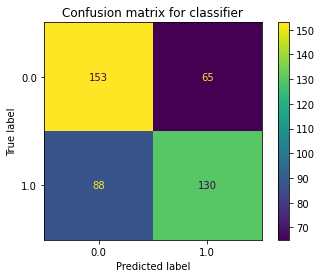

2021-04-20 13:35:27.424441


In [13]:
col = train_labels_1.columns[0]
print(datetime.datetime.now())
train_data_2_0 = train_data_2[train_labels_1[col] == 0.].copy()
train_data_2_1 = train_data_2[train_labels_1[col] == 1.].copy()

#find the min lenght
min_len = min(len(train_data_2_0),len(train_data_2_1))
print(min_len)


# balanced training data sample
train_data_ok = pd.concat([train_data_2_0.sample(min_len),train_data_2_1.sample(min_len)])
print(len(train_data_ok))
#shuffle the sample
train_data_ok = shuffle(train_data_ok)

#choose the right labels using the index and .loc function
train_labels_ok = train_labels_1.loc[train_data_ok.index].copy()
print(len(train_labels_ok))
# split train data into train and validation
X_train, X_test, y_train, y_test = train_test_split(train_data_ok,train_labels_ok, train_size=0.8)
print(len(X_train),len(X_test))
classifier = svm.SVC(probability = True)
classifier.fit(X_train,y_train[col])

#save model into file
filename = 'model20Apr_balanced_'+col +'.sav'
pickle.dump(classifier, open(filename, 'wb'))


y_pred = classifier.predict_proba(X_test)
y_pred = pd.DataFrame(data=y_pred, columns=['prob_0','prob_1'])
print("Column: "+col+" ROC AUC: %.2f" %(metrics.roc_auc_score(y_test[col], y_pred['prob_1'])))
# confusion matrix
matrix = plot_confusion_matrix(classifier, X_test, y_test[col])
plt.title('Confusion matrix for classifier')
plt.show(matrix)
plt.show()
print(datetime.datetime.now())


In [14]:
y_pred

,prob_0,prob_1
0,0.339840,0.660160
1,0.649988,0.350012
2,0.757446,0.242554
3,0.553023,0.446977
4,0.468274,0.531726
...,...,...
431,0.620697,0.379303
432,0.472430,0.527570
433,0.513214,0.486786
434,0.485685,0.514315


## unbalanced data

In [16]:
train_data_ok = train_data_2.copy()
train_data_ok = shuffle(train_data_ok)
train_labels_ok = train_labels_1.loc[train_data_ok.index].copy()
col = train_labels_1.columns[0]
X_train, X_test, y_train, y_test = train_test_split(train_data_ok,train_labels_ok, train_size=0.8)
classifier = svm.SVC(probability = True)
print(datetime.datetime.now())
classifier.fit(X_train,y_train[col])
print(datetime.datetime.now())
y_pred = classifier.predict_proba(X_test)
print(datetime.datetime.now())
y_pred = pd.DataFrame(data=y_pred, columns=['prob_0','prob_1'])
print("ROC AUC: %.2f" %(metrics.roc_auc_score(y_test[col], y_pred['prob_1'])))
#save model into file
filename = 'model20Apr_unbalanced_'+col +'.sav'
pickle.dump(classifier, open(filename, 'wb'))

2021-04-20 13:36:27.119222
2021-04-20 13:40:04.688697
2021-04-20 13:40:13.195396
ROC AUC: 0.59


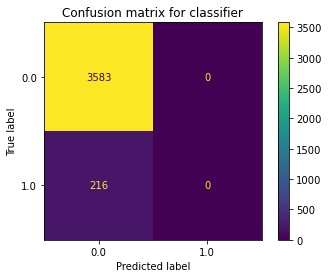

In [17]:
# confusion matrix
matrix = plot_confusion_matrix(classifier, X_test, y_test[col])
plt.title('Confusion matrix for classifier')
plt.show(matrix)
plt.show()

## Run over test data and save output

In [20]:
# output dataframe
output = pd.DataFrame()
col = train_labels_1.columns[0]
print(col)
filename = 'model20Apr_'+col+'.sav'
class_loaded = pickle.load(open(filename, 'rb'))
y_final_pred = class_loaded.predict_proba(test_data_2)
y_final_pred = pd.DataFrame(data=y_final_pred, columns=['prob_0','prob_1'])
#print(y_final_pred)
output[col] = y_final_pred['prob_1']

sample_data = pd.read_csv('dataset/sample.csv', delimiter=',')    
output.reindex(sample_data['pid'].to_numpy())

LABEL_Sepsis


,LABEL_Sepsis
0,0.801046
10001,0.298781
10003,0.271364
10004,0.400946
10005,0.299036
...,...
9989,0.415687
9991,0.479970
9992,0.536248
9994,0.712198


In [22]:
#save into .csv file
file_df = pd.DataFrame()
file_df['pid'] = sample_data['pid']

file_df[col] = output[col]
file_df.to_csv('subtask2.csv', index=False)